<a href="https://colab.research.google.com/github/AkbarIsmayilov/NN_FINAL/blob/main/ElvinCNNnumPy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'After   Convultion ')

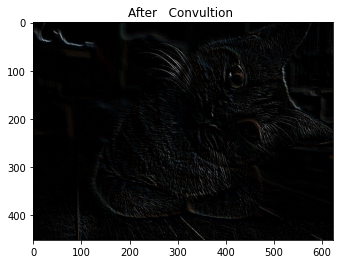

In [6]:
# -*- coding: utf-8 -*-
"""convolution_pooling(stride,padding)_flatten.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1dXrb3n-hHXTQUqLt27ALnFi7txJMH6ls
"""

# Importing libraries
import numpy as np
from numpy.lib.stride_tricks import as_strided
import matplotlib.pyplot as plt
from PIL import Image
import itertools 
from numpy import asarray

# Convolution
def gen_idx_conv1d(in_size, ker_size):
    """
    Generates a list of indices. This indices correspond to the indices
    of a 1D input tensor on which we would like to apply a 1D convolution.

    For instance, with a 1D input array of size 5 and a kernel of size 3, the
    1D convolution product will successively looks at elements of indices [0,1,2],
    [1,2,3] and [2,3,4] in the input array. In this case, the function idx_conv1d(5,3) 
    outputs the following array: array([0,1,2,1,2,3,2,3,4]).

    args:
        in_size: (type: int) size of the input 1d array.
        ker_size: (type: int) kernel size.

    return:
        idx_list: (type: np.array) list of the successive indices of the 1D input array
        access to the 1D convolution algorithm.

    example:
        >>> gen_idx_conv1d(in_size=5, ker_size=3)
        array([0, 1, 2, 1, 2, 3, 2, 3, 4])
    """
    f = lambda dim1, dim2, axis: np.reshape(np.tile(np.expand_dims(np.arange(dim1),axis),dim2),-1)
    out_size = in_size-ker_size+1
    return f(ker_size, out_size, 0)+f(out_size, ker_size, 1)

def repeat_idx_2d(idx_list, nbof_rep, axis):
    """
    Repeats an array of indices (idx_list) a number of time (nbof_rep) "along" an axis
    (axis). This function helps to browse through a 2d array of size
    (len(idx_list),nbof_rep).

    args:
        idx_list: (type: np.array or list) a 1D array of indices.
        nbof_rep: (type: int) number of repetition.
        axis: (type: int) axis "along" which the repetition will be applied.

    return
        idx_list: (type: np.array) a 1D array of indices of size len(idx_list)*nbof_rep.

    example:
        >>> a = np.array([0, 1, 2])
        >>> repeat_idx_2d(a, 3, 0) # repeats array 'a' 3 times along 'axis' 0
        array([0, 0, 0, 1, 1, 1, 2, 2, 2])

        >>> repeat_idx_2d(a, 3, 1) # repeats array 'a' 3 times along 'axis' 1
        array([0, 1, 2, 0, 1, 2, 0, 1, 2])

        >>> b = np.reshape(np.arange(3*4), (3,4))
        >>> b[repeat_idx_2d(np.arange(3), 4, 0), repeat_idx_2d(np.arange(4), 3, 1)]
        array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
    """
    assert axis in [0,1], "Axis should be equal to 0 or 1."
    tile_axis = (nbof_rep,1) if axis else (1,nbof_rep)
    return np.reshape(np.tile(np.expand_dims(idx_list, 1),tile_axis),-1)

def conv2d(im, ker):
    """
    Performs a 'valid' 2D convolution on an image. The input image may be
    a 2D or a 3D array.

    The output image first two dimensions will be reduced depending on the 
    convolution size. 

    The kernel may be a 2D or 3D array. If 2D, it will be applied on every
    channel of the input image. If 3D, its last dimension must match the
    image one.

    args:
        im: (type: np.array) image (2D or 3D).
        ker: (type: np.array) convolution kernel (2D or 3D).

    returns:
        im: (type: np.array) convolved image.

    example:
        >>> im = np.reshape(np.arange(10*10*3),(10,10,3))/(10*10*3) # 3D image
        >>> ker = np.array([[0,1,0],[-1,0,1],[0,-1,0]]) # 2D kernel
        >>> conv2d(im, ker) # 3D array of shape (8,8,3)
    """
    if len(im.shape)==2: # it the image is a 2D array, it is reshaped by expanding the last dimension
        im = np.expand_dims(im,-1)

    im_x, im_y, im_w = im.shape

    if len(ker.shape)==2: # if the kernel is a 2D array, it is reshaped so it will be applied to all of the image channels
        ker = np.tile(np.expand_dims(ker,-1),[1,1,im_w]) # the same kernel will be applied to all of the channels 

    assert ker.shape[-1]==im.shape[-1], "Kernel and image last dimension must match."

    ker_x = ker.shape[0]
    ker_y = ker.shape[1]

    # shape of the output image
    out_x = im_x - ker_x + 1 
    out_y = im_y - ker_y + 1

    # reshapes the image to (out_x, ker_x, out_y, ker_y, im_w)
    idx_list_x = gen_idx_conv1d(im_x, ker_x) # computes the indices of a 1D conv (cf. idx_conv1d doc)
    idx_list_y = gen_idx_conv1d(im_y, ker_y)

    idx_reshaped_x = repeat_idx_2d(idx_list_x, len(idx_list_y), 0) # repeats the previous indices to be used in 2D (cf. repeat_idx_2d doc)
    idx_reshaped_y = repeat_idx_2d(idx_list_y, len(idx_list_x), 1)

    im_reshaped = np.reshape(im[idx_reshaped_x, idx_reshaped_y, :], [out_x, ker_x, out_y, ker_y, im_w]) # reshapes

    # reshapes the 2D kernel
    ker = np.reshape(ker,[1, ker_x, 1, ker_y, im_w])

    # applies the kernel to the image and reduces the dimension back to the one of original input image
    return np.squeeze(np.sum(im_reshaped*ker, axis=(1,3)))

# Pooling 
def pool2d(A, kernel_size, stride, padding=0, pool_mode='max'):
    '''
    2D Pooling
    
    Parameters:
        A: input 2D array
        kernel_size: int, the size of the window over which we take pool
        stride: int, the stride of the window
        padding: int, implicit zero paddings on both sides of the input
        pool_mode: string, 'max' or 'avg'
    '''
    # Padding
    A = np.pad(A, padding, mode='constant')
    
    # Window view of A
    output_shape = ((A.shape[0] - kernel_size) // stride + 1,
                    (A.shape[1] - kernel_size) // stride + 1)
    
    shape_w = (output_shape[0], output_shape[1], kernel_size, kernel_size)
    strides_w = (stride*A.strides[0], stride*A.strides[1], A.strides[0], A.strides[1])
    
    A_w = as_strided(A, shape_w, strides_w)
    
    # Return the result of pooling
    if pool_mode == 'max':
        return A_w.max(axis=(2, 3))
    elif pool_mode == 'avg':
        return A_w.mean(axis=(2, 3))

# Convolution process
image = np.array(Image.open(r"/content/cat.jpg"))
ker = np.array([[0,1,0],[-1,0,1],[0,-1,0]]) # 2D kernel
conv_processed_image = conv2d(image,ker)
# print(conv_processed_image)

plt.imshow(conv_processed_image )
plt.title("After   Convultion ")


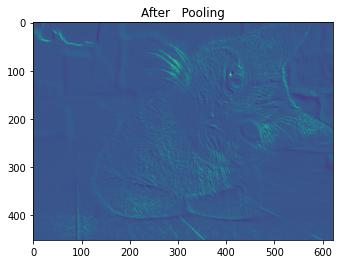

In [7]:
# Pooling process
pool_processed_image = pool2d(conv_processed_image, kernel_size=2, stride=1, padding=0, pool_mode='max')
# print(pool_processed_image)

plt.imshow(pool_processed_image )
plt.title("After   Pooling")

# Flattening process
merged = list(itertools.chain(*pool_processed_image))
print(merged)

Debugging
del conv_processed_image
del pool_processed_image